In [7]:
conda install -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    conda-4.10.3               |   py38h50d1736_0         3.1 MB  conda-forge
    libxgboost-1.3.3           |       h23ab428_0         1.2 MB
    py-xgboost-1.3.3           |   py38hecd8cb5_0         136 KB
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    xgboost-1.3.3              |   py38hecd8cb5_0          23 KB
    ------------------------------------------------------------
                                           Total:  

In [2]:
import xgboost as xgb

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
test_data=pd.read_csv('/Users/jinglinhui/Desktop/Data_analytics_project/log_regression/test.csv')
train_data=pd.read_csv('/Users/jinglinhui/Desktop/Data_analytics_project/log_regression/train.csv')

In [5]:
train_data['Age'] = train_data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))
train_data["Embarked"].fillna(train_data['Embarked'].value_counts().idxmax(), inplace=True)

In [6]:
train_data.drop("Cabin", inplace=True, axis=1)
train_data.drop(['PassengerId'], axis=1,inplace=True)
train_data.drop("Name", inplace=True, axis=1)
train_data.drop("Ticket", inplace=True, axis=1)


In [7]:
train_data["Sex"] = train_data["Sex"].map({'male':1, 'female':0})
embarked =pd.get_dummies(train_data['Embarked'],drop_first=True)
train_data = pd.concat([train_data, embarked], axis=1)
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Q,S
0,0,3,1,22.00,1,0,7.2500,S,0,1
1,1,1,0,38.00,1,0,71.2833,C,0,0
2,1,3,0,26.00,0,0,7.9250,S,0,1
3,1,1,0,35.00,1,0,53.1000,S,0,1
4,0,3,1,35.00,0,0,8.0500,S,0,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.00,0,0,13.0000,S,0,1
887,1,1,0,19.00,0,0,30.0000,S,0,1
888,0,3,0,21.75,1,2,23.4500,S,0,1
889,1,1,1,26.00,0,0,30.0000,C,0,0


In [8]:
train_data.drop("Embarked", inplace=True, axis=1)

In [9]:
train_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Q           0
S           0
dtype: int64

In [10]:
test_data['Age'] = test_data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))
test_data["Embarked"].fillna(test_data['Embarked'].value_counts().idxmax(), inplace=True)
test_data["Sex"] = test_data["Sex"].map({'male':1, 'female':0})
embarked_test = pd.get_dummies(test_data["Embarked"], drop_first=True)
test_data = pd.concat([test_data, embarked_test], axis=1)
test_data["Fare"].fillna(test_data["Fare"].mean(skipna=True), inplace=True)

In [11]:
test_data = test_data.drop(['PassengerId'], axis=1)
test_data.drop('Cabin', axis=1, inplace=True)
test_data.drop("Name", inplace=True, axis=1)
test_data.drop("Ticket", inplace=True, axis=1)
test_data.drop("Embarked", inplace=True, axis=1)

In [12]:
test_data.isnull().sum()

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
Q         0
S         0
dtype: int64

In [13]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]

In [54]:
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)

In [267]:
param_grid = {'eta': [0.1,0.2, 0.3],#'objective':'binary:logistic'
              'max_depth': [5, 6, 7],
              'colsample_bytree': [0.5,0.7,1],
              'objective': "binary:logistic",
              'eval_metric': "auc"
             }

In [268]:
import itertools as it
parameters = it.product(*(param_grid[title] for title in list(param_grid)))
print(list(param_grid))

['eta', 'max_depth', 'colsample_bytree', 'objective', 'eval_metric']


In [269]:
def cross_validation_split(dataset, folds):
        dataset_split = []
        fold_size = int(X_train.shape[0] / folds) #number of rows in each fold
        ini_index=[0] #start from index 0
        remains= fold_size % folds 
        
        
        # for loop to save each fold
        for i in range(1,remains):
            ini_index.append(i*fold_size+1)

        for j in range (remains, folds+1):
            ini_index.append(j*fold_size+remains)

            # save the fold     
        for n in range(len(ini_index)-1):
            dataset_split.append([ini_index[n], ini_index[n+1]])
            
        return dataset_split 

In [270]:
index=cross_validation_split(X_train,5)
index

[[0, 179], [179, 357], [357, 537], [537, 715], [715, 893]]

In [271]:
def xg_boost(X_train, Y_train,param,n_round,es_round, k):
    index=cross_validation_split(X_train,k)
    
    br = []
    score=[]
    for i in range(k):
        
        cv_xtest = X_train.iloc[index[i][0]:index[i][1],:]
        cv_ytest = Y_train.iloc[index[i][0]:index[i][1],]
    
        cv_xtrain = X_train.drop(X_train.index[index[i][0]:index[i][1]])
        cv_ytrain = Y_train.drop(X_train.index[index[i][0]:index[i][1]])
        
        d_train = xgb.DMatrix(data = cv_xtrain, label = cv_ytrain)
        d_test = xgb.DMatrix(data = cv_xtest, label = cv_ytest)
        xgb_train = xgb.train(params = param,dtrain = d_train,num_boost_round = n_round,
                              early_stopping_rounds = es_round,
                              evals=[(d_train,'train'),(d_test, 'test')])
        
        #use auc to evaluate 
        #fpr, tpr, threshold = roc_curve(cv_ytest, xgb_train.predict(d_test))
        #auc_roc = metrics.auc(fpr, tpr)
        #auc.append(auc_roc)
        best_round = xgb_train.best_iteration
        value = xgb_train.best_score
        score.append(value)
        br.append(best_round)
    
    return np.mean(score),np.mean(br),best_round               


In [273]:
sc=[]
for i in list(parameters):
    param_opt = {'eta': i[0], 
                 'max_depth': i[1],
                 'colsample_bytree': i[2],
                 'objective':'binary:logistic',
                 'eval_metric' : 'auc'
                }
    best_round = xg_boost(X_train, Y_train,param_opt, 2000, 50,5)
    sc.append(best_round)
    
print(best_round,i)

(0.8802215999999999, 142.6, 180) (0.1, 5, 0.5, 'b', 'a')


In [274]:
best_param = {'objective':'binary:logistic','eta': 0.1,'max_depth': 5, 'colsample_bytree': 0.5,'eval_metric':'auc'}

In [275]:
xg_reg = xgb.train(params=best_param, dtrain=data_dmatrix, num_boost_round=180)

In [276]:
pred=xg_reg.predict(data_dmatrix)
test_matrix= xgb.DMatrix(test_data)
ypreds_proba = xg_reg.predict(test_matrix)

No handles with labels found to put in legend.


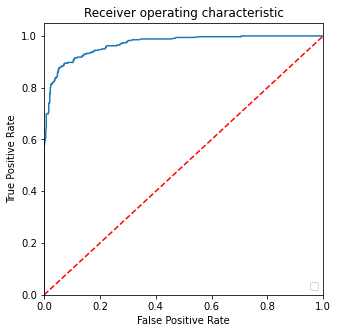

In [277]:
[fpr, tpr, thr]= roc_curve(Y_train,pred)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [278]:
print("AUC: %2.3f" % auc(fpr, tpr))

AUC: 0.969


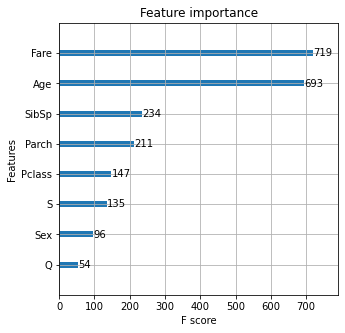

In [279]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [280]:
train_proba = pd.DataFrame({'survival_probability' : pred})
train_proba

,survival_probability
0,0.050769
1,0.989268
2,0.510405
3,0.994945
4,0.103478
...,...
886,0.196239
887,0.982270
888,0.184052
889,0.755916


In [286]:
acc=[]
pre=[]
rec=[]
for i in np.arange(0, 1,0.1):
    def filter_prob(p):
        if p['survival_probability'] >= i:
            return "1"
        else:
            return "0"
    train_proba['Survived_predict']= train_proba.apply(filter_prob,axis=1)
    #print(train_proba.Survived_predict)
    #print(Y_train)
    cm = confusion_matrix(Y_train,train_proba.Survived_predict.astype('int'))
    #Accuracy (all correct / all) = TP + TN /all
    accuracy = (cm[0][0]+cm[1][1])/891
    #print(accuracy)
    #precision =TP/(TP+FP)
    precision=cm[0][0]/(cm[0][0]+cm[0][1])
    #recall=TP/(TP+FN)
    recall=cm[0][0]/(cm[0][0]+cm[1][1])
    acc.append(accuracy)
    pre.append(pre)
    rec.append(recall)
    
print(i,accuracy.max())
print(i,precision.max())
print(i,recall.max())

0.9 0.7890011223344556
0.9 1.0
0.9 0.7809388335704125


In [234]:
test_table = pd.DataFrame({'test_survive_probability' : ypreds_proba})
test_table

,test_survive_probability
0,0.186437
1,0.379891
2,0.238375
3,0.188411
4,0.676035
...,...
413,0.188411
414,0.847625
415,0.186437
416,0.188411


In [287]:
def filter_prob(p):
        if p['test_survive_probability'] >= 0.9:
            return "1"
        else:
            return "0"
test_table['Survived_predict']= test_table.apply(filter_prob,axis=1)

In [288]:
test_table

,test_survive_probability,Survived_predict
0,0.186437,0
1,0.379891,0
2,0.238375,0
3,0.188411,0
4,0.676035,0
...,...,...
413,0.188411,0
414,0.847625,0
415,0.186437,0
416,0.188411,0
